In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.svm import LinearSVC

In [65]:
session = "Pilot5"
data_dir = f"/Users/thenning/Documents/GitHub/neurobubbles/Data/{session}"
order_data = pd.read_csv((glob.glob(f"{data_dir}/orders*.csv"))[0])
round_data = pd.read_csv((glob.glob(f"{data_dir}/rounds*.csv"))[0])
payments_data = pd.read_csv((glob.glob(f"{data_dir}/payment*.csv"))[0])
prescreen_data = pd.read_csv((glob.glob(f"{data_dir}/prescreen*.csv"))[0])
pagetime_data = pd.read_csv((glob.glob(f"{data_dir}/PageTimes*.csv"))[0])


# Order Data

In [66]:
sell_orders = []
min_sell_price = []
buy_orders = []
max_buy_price = []
market_price = []
for round in np.unique(order_data['round_number']):
    if round > 3:
        df = order_data[order_data['round_number']== round]
        sell_orders.append(np.sum(df[df['type'] == 'SELL']['quantity']))
        min_sell_price.append(np.min(df[df['type'] == 'SELL']['price']))
        buy_orders.append(np.sum(df[df['type'] == 'BUY']['quantity']))
        max_buy_price.append(np.max(df[df['type'] == 'BUY']['price']))
        market_price.append(np.unique(df['market_price']))
    else:
        print("skipping practice round", round)

#turning into numpy arrays cause its nice
sell_orders_array = np.array(sell_orders)
min_sell_price_array = np.array(min_sell_price)
buy_orders_array = np.array(buy_orders)
max_buy_price_array = np.array(max_buy_price)
market_price_array = np.array(market_price)

(sell_orders)

skipping practice round 1
skipping practice round 2
skipping practice round 3


[33,
 24,
 22,
 33,
 25,
 18,
 16,
 27,
 26,
 14,
 22,
 23,
 15,
 10,
 14,
 2,
 18,
 16,
 30,
 27,
 18,
 21,
 29,
 19,
 30,
 35,
 42,
 47,
 41,
 30]

## Buy and Sell info

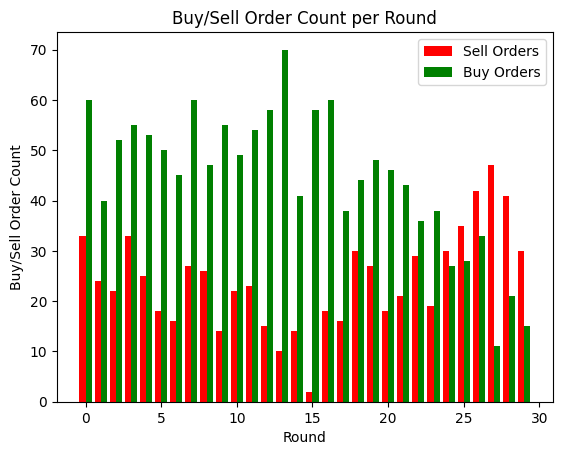

In [67]:
num_rounds = len(sell_orders)  # Assuming both sell_orders and buy_orders have the same length (number of rounds)
rounds = np.arange(num_rounds)


plt.bar(rounds - 0.2, sell_orders, width=0.4, label='Sell Orders', color='red')  # Shift bars to the left, color red
plt.bar(rounds + 0.2, buy_orders, width=0.4, label='Buy Orders', color='green')   # Shift bars to the right, color green
plt.xlabel('Round')
plt.ylabel('Buy/Sell Order Count')
plt.title('Buy/Sell Order Count per Round')
plt.legend()
plt.show()


In [68]:
def get_negative_inflection(buy_orders, sell_orders, session, hide_graph = "no"):
    buy_sell_diff = []
    for round,ask_count in enumerate(sell_orders):
        bid_count = buy_orders[round]
        if (ask_count > bid_count) and not (sell_orders[round-1] > buy_orders[round-1]):
            buy_sell_diff.append(1)
        else:
            buy_sell_diff.append(0)
    np.array(buy_sell_diff)

    if hide_graph == "yes":
        plt.plot(buy_sell_diff)
        plt.title(f"{session} Bid_Ask Change")
    
    return buy_sell_diff

buy_sell_diff = get_negative_inflection(buy_orders, sell_orders, session)
len(buy_sell_diff)

30

## Lag Price

In [69]:

def price_change(idx, market_price_array):
    if idx == 0:
        prev = 0
    else:
        prev = market_price_array[idx-1]
    return market_price_array[idx] - prev

def get_lag_price(market_price_array, hide_graph = "no"):
    lag_price = []
    for round,price in enumerate(market_price_array):
        lag_price.append(price_change(round, market_price_array))
    
    if hide_graph == "yes":
        plt.plot(lag_price)
        plt.hlines(0, xmin=0, xmax=len(lag_price)-1, colors='r', linestyles='dashed')
        plt.xlabel('Round')
        plt.ylabel('Price Change')
        plt.title('Lagged Price Changes')
        plt.show()
    return lag_price


lag_price = get_lag_price(market_price_array)


In [70]:
def period_mv_avg(idx, market_price_array, period, include_beg="no"):
    if idx < period:
        if include_beg == 'yes':
            mv_avg = np.mean(market_price_array[:idx])
        else:
            mv_avg = 14
    else:
        mv_avg = np.mean(market_price_array[idx-period:idx])

    return mv_avg

def get_moving_average(market_price_array, period, include_beg="no",hide_graph = 'no'):
    if include_beg == 'yes':
        print(f""" Note: You are including in the moving average periods that do not have {period} rounds of previous data. 
        The means for those periods will be a simple average of the periods up until this point from index 0. 
        If you want to exclude then the include_beg parameter should be set to no.""")
    
    mv_avg = []
    for round, price in enumerate(market_price_array):
        mv_avg.append(period_mv_avg(round, market_price_array, 3, include_beg= include_beg))
    if hide_graph == "yes":
        plt.plot(mv_avg)
        plt.hlines(14, xmin=0, xmax=len(lag_price)-1, colors='r', linestyles='dashed')
        plt.xlabel('Round')
        plt.ylabel("Price")
        plt.title(f'{period} Price moving averge')
        plt.show()
    return lag_price

mv_avg3 = get_moving_average(market_price_array, 3, "no", "no")

## Forcast Error

Text(0.5, 1.0, 'Forecast Error 11-period')

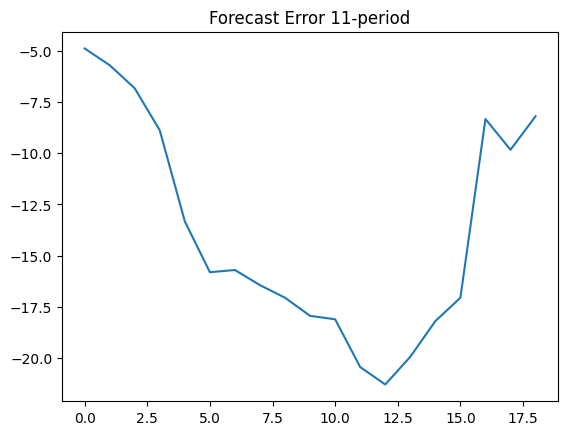

In [71]:
def get_forecast_data(round_data):
    f1mean_forecast=[]
    f2mean_forecast=[]
    f3mean_forecast=[]
    f4mean_forecast=[]
    for i in np.unique(round_data['subsession.round_number']):
        if i > 3:
            r1 = round_data[round_data['subsession.round_number'] == i]
            f1mean_forecast.append(np.mean(r1['player.f0']))
            f2mean_forecast.append(np.mean(r1['player.f1']))
            f3mean_forecast.append(np.mean(r1['player.f2']))
            f4mean_forecast.append(np.mean(r1['player.f3']))
    return [f1mean_forecast, f2mean_forecast, f3mean_forecast, f4mean_forecast]

def forecast_error(round_data,market_price_array, t, m):
    forecasts = get_forecast_data(round_data)
    if m == 1:
        forecast_array = forecasts[0]
    elif m == 3:
        forecast_array = forecasts[1]
    elif m == 6:
        forecast_array = forecasts[2]
    elif m == 11:
        forecast_array = forecasts[3]

    forecast_error = forecast_array[t-m] - market_price_array[t]
    return forecast_error

def generate_forecast_error(round_data, market_price_array, m):
    forecast_error_array = []
    for t, price in enumerate(market_price_array):
        if t < m:
            error = None
        else:
            error = forecast_error(round_data, market_price_array, t, m)
        forecast_error_array.append(error)
    return forecast_error_array

m = 11
errors = generate_forecast_error(round_data, market_price_array, m)
plt.plot(errors[m:])
plt.title(f"Forecast Error {m}-period")

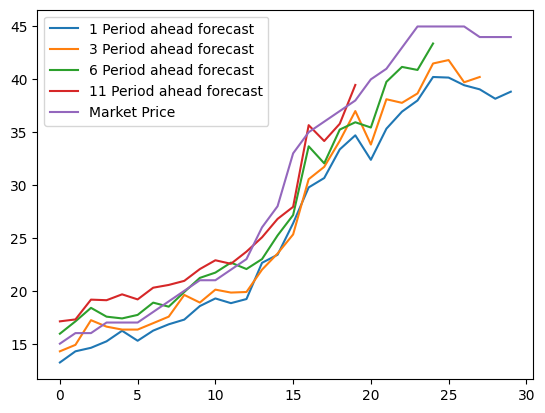

In [72]:
f1mean_forecast=[]
f2mean_forecast=[]
f3mean_forecast=[]
f4mean_forecast=[]
for i in np.unique(round_data['subsession.round_number']):
    if i > 3:
        r1 = round_data[round_data['subsession.round_number'] == i]
        f1mean_forecast.append(np.mean(r1['player.f0']))
        f2mean_forecast.append(np.mean(r1['player.f1']))
        f3mean_forecast.append(np.mean(r1['player.f2']))
        f4mean_forecast.append(np.mean(r1['player.f3']))

plt.plot(f1mean_forecast, label='1 Period ahead forecast')
plt.plot(f2mean_forecast, label='3 Period ahead forecast')
plt.plot(f3mean_forecast, label='6 Period ahead forecast')
plt.plot(f4mean_forecast, label='11 Period ahead forecast')
plt.plot(market_price_array, label='Market Price')
plt.legend()
plt.show()

## Volume

In [73]:
def lag_volume(buy_orders, sell_orders, t):
    volume = np.add(buy_orders, sell_orders)
    if t < 1:
        lag_volume = None
    else:
        lag_volume= volume[t-1]
    return lag_volume


In [ ]:
def prev_round_volume(buy_orders, sell_orders, t):
    buy = buy_orders
    volume = np.add(buy_orders, sell_orders)
    if t < 1:
        lag_volume = None
    else:
        lag_volume= volume[t-1]
    return lag_volume


In [124]:
buy_orders

[41,
 43,
 49,
 60,
 40,
 52,
 55,
 53,
 50,
 45,
 60,
 47,
 55,
 49,
 54,
 58,
 70,
 41,
 58,
 60,
 38,
 44,
 48,
 46,
 43,
 36,
 38,
 27,
 28,
 33,
 11,
 21,
 15]

## Orderbook Pressure

In [74]:
def get_orderbook_pressure_per_round(order_data, t):
    round_data = order_data[order_data['round_number']== t]
    market_price = np.unique(round_data['market_price'])[0]

    buy_d = round_data[round_data['type'] =='BUY']
    max_unfilled_bid = np.max(buy_d[buy_d['price'] <market_price]['price'])
    bid_quantity = np.sum(buy_d[buy_d['price'] ==max_unfilled_bid]['quantity'])

    ask_d = round_data[round_data['type'] =='SELL']
    min_unfilled_ask = np.min(ask_d[ask_d['price'] > market_price]['price'])
    ask_quantity = np.sum(ask_d[ask_d['price'] ==min_unfilled_ask]['quantity'])

    obook_pressure = (max_unfilled_bid * bid_quantity + min_unfilled_ask * ask_quantity)/(bid_quantity+ask_quantity)
    return obook_pressure

order_book_pressure = []
for round in np.unique(order_data['round_number']):
    if round > 3:
        order_book_pressure.append(get_orderbook_pressure_per_round(order_data, round))
order_book_pressure

[14.375,
 15.64516129032258,
 15.6,
 16.857142857142858,
 16.20689655172414,
 16.416666666666668,
 17.347826086956523,
 19.166666666666668,
 20.555555555555557,
 20.476190476190474,
 21.0,
 21.517241379310345,
 22.571428571428573,
 25.571428571428573,
 27.5,
 nan,
 35.0,
 36.333333333333336,
 37.10344827586207,
 37.96,
 39.44444444444444,
 40.23529411764706,
 42.07142857142857,
 45.333333333333336,
 45.2,
 45.45454545454545,
 44.75,
 44.5,
 nan,
 42.375]

## Asset Allocation

In [75]:
def get_asset_allocation(round_data, t):
    if t < 1:
        price = 14
    else:
        price = np.unique(round_data[round_data['subsession.round_number']== 4]['group.price'])[0]
    player_cash = np.sum(round_data[round_data['subsession.round_number']== t]['player.cash'])
    stock_value = np.sum(r1['player.shares'])* price
    return player_cash/stock_value

get_asset_allocation(round_data, 8)


2.2249259259259255

# Round by Round Data

In [77]:
sell_orders = []
min_sell_price = []
buy_orders = []
max_buy_price = []
market_price = []
for round in np.unique(order_data['round_number']):
    df = order_data[order_data['round_number']== round]
    sell_orders.append(np.sum(df[df['type'] == 'SELL']['quantity']))
    min_sell_price.append(np.min(df[df['type'] == 'SELL']['price']))
    buy_orders.append(np.sum(df[df['type'] == 'BUY']['quantity']))
    max_buy_price.append(np.max(df[df['type'] == 'BUY']['price']))
    market_price.append(np.unique(df['market_price']))


#turning into numpy arrays cause its nice
sell_orders_array = np.array(sell_orders)
min_sell_price_array = np.array(min_sell_price)
buy_orders_array = np.array(buy_orders)
max_buy_price_array = np.array(max_buy_price)
market_price_array = np.array(market_price)


In [92]:
def get_negative_inflection(buy_orders, sell_orders, session, hide_graph = "no"):
    buy_sell_diff = []
    for round,ask_count in enumerate(sell_orders):
        bid_count = buy_orders[round]
        if (ask_count > bid_count) and not (sell_orders[round-1] > buy_orders[round-1]):
            buy_sell_diff.append(1)
        else:
            buy_sell_diff.append(0)
    np.array(buy_sell_diff)

    if hide_graph == "yes":
        plt.plot(buy_sell_diff)
        plt.title(f"{session} Bid_Ask Change")
    
    return buy_sell_diff

negative_inflection = get_negative_inflection(buy_orders, sell_orders, session)

In [103]:
len(negative_inflection)

33

In [119]:
negative_inflection = get_negative_inflection(buy_orders, sell_orders, session)
lag_price = get_lag_price(market_price_array)
m = 11
nerrors = generate_forecast_error(round_data, market_price_array, m)
forecast_period_list = [1,2,5,10]

round_ml_data = {
    'order_book_pressure': [],
    'negative_inflection': [],
    'lag_price': [],
    'lag_volume': [],
    'asset_allocation': []
}

# Populate the lists with values for each round
for round in np.unique(order_data['round_number']):
    if round > 3:
        round_ml_data['order_book_pressure'].append(get_orderbook_pressure_per_round(order_data, round))
        round_ml_data['negative_inflection'].append(negative_inflection[round - 1])
        round_ml_data['lag_price'].append(lag_price[round - 1][0])
        round_ml_data['lag_volume'].append(lag_volume(buy_orders, sell_orders, round - 1))
        round_ml_data['asset_allocation'].append(get_asset_allocation(round_data, round - 1))





In [123]:
round_ml_data_df = pd.DataFrame.from_dict(round_ml_data)
round_ml_data_df

,order_book_pressure,negative_inflection,lag_price,lag_volume,asset_allocation
0,14.375000,0,-2.0,76,1.974167
1,15.645161,0,1.0,93,1.666667
2,15.600000,0,0.0,64,1.776667
3,16.857143,0,1.0,74,1.932167
4,16.206897,0,0.0,88,2.055463
5,16.416667,0,0.0,78,2.224926
6,17.347826,0,1.0,68,2.402833
7,19.166667,0,1.0,61,2.549630
8,20.555556,0,1.0,87,2.743787
9,20.476190,0,1.0,73,2.947648


In [114]:
for m in forecast_period_list:
    nerrors = generate_forecast_error(round_data, market_price_array, m)
    if errors[round-1][0] == None:
        errors[round-1][0] = 0
    round_ml_data[f'{m}_forecast_error'] = errors[round-1][0]

IndexError: list index out of range

IndexError: list index out of range